# TESTING OLD ARCHITECTURES FOR ASL

## Installing packages and downloading dataset

In [1]:
%pip install tensorflow
%pip install matplotlib
%pip install opencv-python
%pip install numpy
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need t

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.model_selection import train_test_split

/Users/ezk/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
!wget https://media.githubusercontent.com/media/ayeshatasnim-h/Indian-Sign-Language-dataset/main/dataset_ISL.zip?download=true -O dataset_ISL.zip
!mkdir dataset_ISL
!unzip dataset_ISL.zip -d dataset_ISL

In [66]:
#quickly checking the number of classes
!find dataset_ISL -type d -mindepth 1 | wc -l
!rm -rf dataset_ISL/.DS_Store

      26


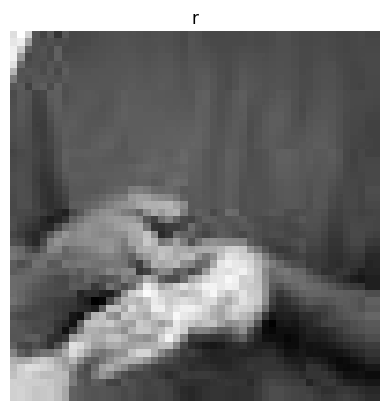

In [7]:
DATADIR = 'dataset_ISL'
CATEGORIES = os.listdir(DATADIR)
BATCH_SIZE = 32
#Visualizing the first image from the dataset
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array,cmap='gray')
        plt.title(category)
        plt.axis('off')
        break
    break

In [69]:
#Re-sizing to 32x32 as per LeNet-5 architecture
IMG_SIZE = 32
X=[]
y=[]
training_data=[]
def create_training_data():
    training_data=[]
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
          img_array = cv2.imread(os.path.join(path,img))
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
          training_data.append([new_array,class_num])
    return training_data



In [70]:
# creating the target and features
def create_input(rgb):
    X=[]
    y=[]
    for feature,label in training_data:
        X.append(feature)
        y.append(label)
    if rgb:
        X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)
    else:
        X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
    y_one_hot = tf.keras.utils.to_categorical(y,num_classes=len(CATEGORIES))
    y_one_hot = np.array(y_one_hot).reshape(-1,len(CATEGORIES))
    return X,y_one_hot

In [71]:
def data_augmentation(image,label,rgb=True):
    # Example data augmentation operations

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.1, upper=0.2)
    if not rgb:
      image = tf.image.rgb_to_grayscale(image)

    return image,label

In [72]:
training_data=create_training_data()
random.shuffle(training_data)
X,y=create_input(rgb=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
X_train,y_train = data_augmentation(X_train,y_train,rgb=False)
X_test = tf.image.rgb_to_grayscale(X_test)

'c'

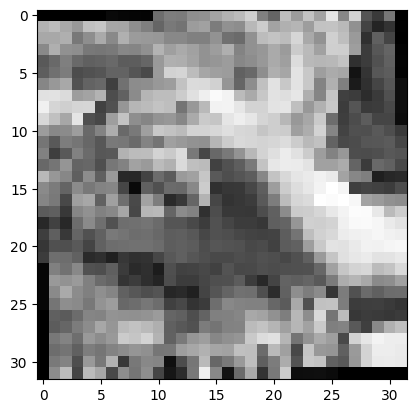

In [73]:
i=12
plt.imshow(np.array(X_train[i]),cmap='gray')
CATEGORIES[np.argmax(y_train[i])]

In [74]:
print('X_train :',X_train.shape)
print('y_train :',y_train.shape)
print('X_test :',X_test.shape)
print('test :',y_test.shape)

X_train : (10109, 32, 32, 1)
y_train : (10109, 26)
X_test : (2528, 32, 32, 1)
test : (2528, 26)


## LeNet-5


### NOTES :  

- LeNet-5 uses activations after pooling rather than after convolutions

- it pretty much exclusively uses tanh/sigmoid for activation except the  output layer

![LeNet-5](Assets/LeNet-5.svg)

In [84]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,1)),
    tf.keras.layers.Conv2D(6,(5,5),1,kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.AveragePooling2D((2,2),2),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.Conv2D(16,(5,5),1,kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.AveragePooling2D((2,2),2),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120,activation='tanh',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Dense(84,activation='tanh',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Dense(len(CATEGORIES),activation='softmax'),

])

In [85]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 26)             │         2,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,066 (246.35 KB)

 Trainable params: 63,066 (246.35 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
History = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=20,
          validation_data=(X_test,y_test))

Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0385 - loss: 5.1678 - val_accuracy: 0.0392 - val_loss: 3.5407
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0429 - loss: 3.4404 - val_accuracy: 0.0882 - val_loss: 3.2616
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0494 - loss: 3.3003 - val_accuracy: 0.0720 - val_loss: 3.2282
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0558 - loss: 3.2643 - val_accuracy: 0.0657 - val_loss: 3.2062
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0539 - loss: 3.2568 - val_accuracy: 0.0665 - val_loss: 3.2418
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0530 - loss: 3.2587 - val_accuracy: 0.0491 - val_loss: 3.2783
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0432 - loss: 3.2861 - val_accuracy: 0.0815 - val_loss: 3.2293
Epoch 8/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0842 - loss: 3.1899 - val_accuracy: 0.

79/79 - 0s - 2ms/step - accuracy: 0.1562 - loss: 3.5040


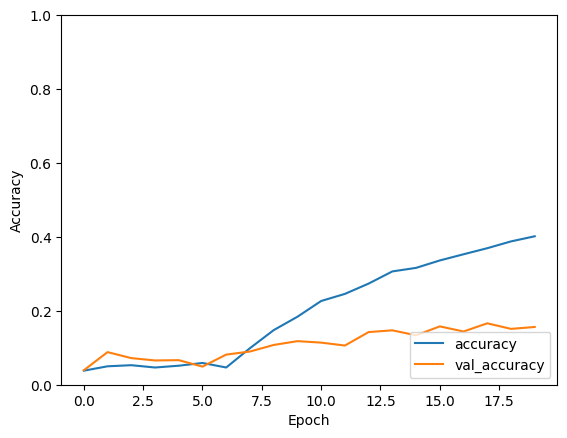

In [88]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
model prediction : g


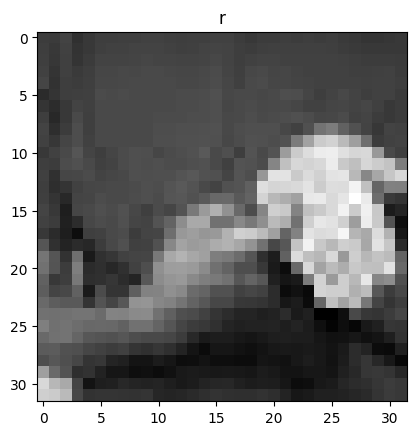

In [89]:
i=33
plt.title(CATEGORIES[np.argmax(y_test[i])])
plt.imshow(X_test[i],cmap='gray')
print('model prediction :',CATEGORIES[np.argmax(model.predict(np.array(X_test[i]).reshape(-1,32,32,1)))])

In [91]:
model.save('models/LeNet5.keras')

### ANALYSIS :
- firstly the dataset is quite small for from scratch training of ASL , normally one would use this on a pre-trained model and its hard not to overfit the dataset

- 32x32 images as input are bad in this situation, even the human eye can barely differentiate a lot of the ASL signs. 1 and r for example

- the data augmentation for training set helps mitigate the overfitting to an extent but as soon as input goes beyond 32x32 , the model seemingly overfits training set

- LeNet-5 also uses way less parameters compared to modern CNNs and also uses some weird techniques like activating after pooling

## ALEXNET

![AlexNet](Assets/AlexNet.svg)

In [92]:
#using a generator to feed input images rather than loading all the images to RAM(RGB images take 3x the RAM)
IMG_SIZE=227
train = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'training'
    )

Found 12637 files belonging to 26 classes.
Using 11374 files for training.


In [93]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'validation'
    )

Found 12637 files belonging to 26 classes.
Using 1263 files for validation.


In [94]:
train=train.map(data_augmentation)

In [99]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    tf.keras.layers.Dense(units=4096,activation='relu',),
    tf.keras.layers.Dense(units=len(CATEGORIES),activation='softmax'),

])

In [100]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [101]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 26)             │       106,522 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,387,866 (222.73 MB)

 Trainable params: 58,387,866 (222.73 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                     )

Epoch 1/20
 22/356 ━━━━━━━━━━━━━━━━━━━━ 5:17 950ms/step - accuracy: 0.0385 - loss: 154.7277

KeyboardInterrupt: 

134/134 - 3s - 24ms/step - accuracy: 0.8514 - loss: 1.8768


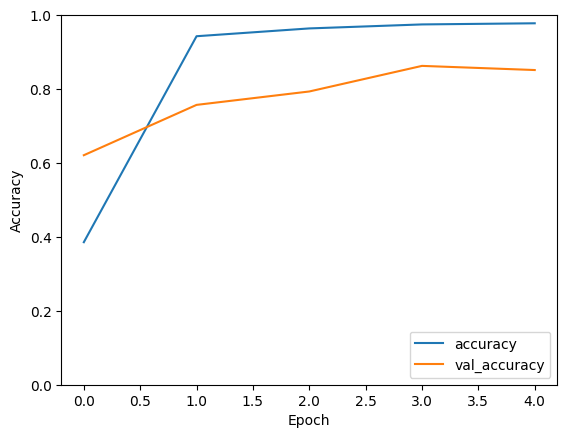

In [ ]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(val, verbose=2)

In [ ]:
model.save('models/AlexNet.keras')

## VGG-16

In [5]:
IMG_SIZE = 224

In [21]:
model= tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.Dense(len(CATEGORIES),activation='relu')
])

In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [23]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 26)             │       106,522 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,367,066 (512.57 MB)

 Trainable params: 134,367,066 (512.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                     )

In [ ]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(val, verbose=2)

In [ ]:
model.save('models/VGG16.keras')